**Multi-Step LSTM Time Series Forecasting Models for Power Usage**\
**ConvLSTM**

Souce: https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/ \
Recreated by: Didit Adytia (didit.adytia@gmail.com)\
Version 7 Aug 2021\

**CASE: Household power consumption**

**MODELS:**
- Univariate and multivariate Encoder-Decoder LSTMs for multi-step time series forecasting.
- CNN-LSTM Encoder-Decoder model for multi-step time series forecasting
- ConvLSTM Encoder-Decoder model for multi-step time series forecasting.



In [13]:
# LOADING PACKAGES
# load and clean-up data
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric
from numpy import split
from numpy import array
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
# from tensorflow.keras.layers.convolutional import Conv1D
# from tensorflow.keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D

import datetime
import timeit
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates 

In [14]:
# 1. DATA PROCESSING
# 1.a. LOADING AND MISSING VALUES --> CREATE New Data .CSV
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

# load all data
dataset = read_csv('input/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime']) 
dataset.replace('?', nan, inplace=True)  # mark all missing values
dataset = dataset.astype('float32')      # make dataset numeric
fill_missing(dataset.values)             # fill missing
values = dataset.values                  # add a column for for the remainder of sub metering
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
dataset.to_csv('household_power_consumption.csv')  # save updated dataset
dataset[:5]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0,71.800003
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0,43.099998


In [15]:
# 1.b. RESAMPLE DATA from Min to Total Each Day (DIALY DATA) --> create new data .CSV
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
daily_groups = dataset.resample('D')   # resample data to daily
daily_data = daily_groups.sum()

print(daily_data.shape)     # summarize
print(daily_data.head())

daily_data.to_csv('household_power_consumption_days.csv')   # save the daily data as ***_days.csv
# daily_data[:5]

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

In [16]:
# 1.c. SPLIT DAYA INTO STANDARD WEEKS

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test  = array(split(test, len(test)/7))
    return train, test

# load the new file : DAIL
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)       # split the values

print(train.shape)                       # validate train data
print(train[0, 0, 0], train[-1, -1, 0])

print(test.shape)                        # validate test
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


In [17]:
# PREPROCESSING
# split a univariate dataset into train/test sets
def split_dataset(data):
    train, test = data[1:-328], data[-328:-6]  # split into standard weeks
    
    train= array(split(train, len(train)/7))  # restructure into windows of weekly data
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i]) # calculate mse
        rmse = sqrt(mse)         # calculate rmse
        scores.append(rmse)      # store
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

#------------------------ MODELS: MODEL 1  ---------------------------------#
# 1. FOR LSTM UNIVARIATE input & vector output model
# 1.a. convert history into inputs and outputs: FOR LSTM-UNIVARIATE
def to_supervised_LSTM_U(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        in_end = in_start + n_input  # define the end of the input sequence
        out_end = in_end + n_out
        if out_end < len(data):      # ensure we have enough data for this instance
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))    # there is slightly different that the script for ConvLSTM
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1                # move along one time step
    return array(X), array(y)

# 1.b. train the model: LSTM with UNIVARIATE Input and Vector Output
def build_model_LSTM_U(train, n_input):
    # prepare data
    train_x, train_y = to_supervised_LSTM_U(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# 1.c. make a forecast: LSTM univariate model
def forecast_LSTM_U(model, history, n_input):
    data = array(history)             # flatten data
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-n_input:, 0]      # retrieve last observations for input data
    input_x = input_x.reshape((1, len(input_x), 1))  # reshape into [1, n_input, 1]
    
    yhat = model.predict(input_x, verbose=0)   # forecast the next week
    yhat = yhat[0]                   # we only want the vector forecast
    return yhat

# 1.d. evaluate a single model : LSTM univariate model
def evaluate_model_LSTM_U(train, test, n_input):
    model = build_model_LSTM_U(train, n_input)     # fit model
    history = [x for x in train]         # history is a list of weekly data
    
    predictions = list()                 # walk-forward validation over each week
    for i in range(len(test)):
        yhat_sequence = forecast_LSTM_U(model, history, n_input) # predict the week
        predictions.append(yhat_sequence)   # store the predictions
        history.append(test[i, :])          # get real observation and add to history for predicting the next week
    predictions = array(predictions)  # evaluate predictions days for each week
    datatest    = test[:, :, 0]
    score, scores = evaluate_forecasts(datatest, predictions)
    return score, scores, predictions, datatest

#------------------------ MODELS: MODEL 2  ---------------------------------#
# 2. MODEL: Encoder-Decoder LSTM Model With Univariate Input
# 2.a. convert history into inputs and outputs: --> same as LSTM univariate
# 2.c. make a forecast: LSTM univariate model:  --> same as LSTM univariate

# 2.b. train the model: ED-LSTM with UNIVARIATE Input 
def build_model_EDLSTM_U(train, n_input):
    # prepare data
    train_x, train_y = to_supervised_LSTM_U(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# 2.d. evaluate a single model: ED-LSTM with UNIVARIATE Input 
def evaluate_model_EDLSTM_U(train, test, n_input):
    model = build_model_EDLSTM_U(train, n_input)     # fit model
    history = [x for x in train]         # history is a list of weekly data
    
    predictions = list()                 # walk-forward validation over each week
    for i in range(len(test)):
        yhat_sequence = forecast_LSTM_U(model, history, n_input) # predict the week
        predictions.append(yhat_sequence)   # store the predictions
        history.append(test[i, :])          # get real observation and add to history for predicting the next week
    predictions = array(predictions)  # evaluate predictions days for each week
    datatest    = test[:, :, 0]
    score, scores = evaluate_forecasts(datatest, predictions)
    return score, scores, predictions, datatest

#------------------------ MODELS: MODEL 3  ---------------------------------#
# 3. MODEL: Encoder-Decoder LSTM Model With MULTIVARIATE Input
# 3.a. convert history into inputs and outputs: 
def to_supervised_EDLSTM_M(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        in_end = in_start + n_input  # define the end of the input sequence
        out_end = in_end + n_out
        if out_end < len(data):      # ensure we have enough data for this instance
            X.append(data[in_start:in_end, :])   # these are differences between LSTM UNIVARIATE and MULTIVARIATE
            y.append(data[in_end:out_end, 0])
        in_start += 1                # move along one time step
    return array(X), array(y)

# 3.b. train the model: Encoder-Decoder LSTM Model With Multivariate Input
def build_model_EDLSTM_M(train, n_input):
    # prepare data
    train_x, train_y = to_supervised_EDLSTM_M(train, n_input)  # using ED-LSTM-MULTIVARIATE version
    # define parameters
    verbose, epochs, batch_size = 1, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# 3.c. make a forecast: Encoder-Decoder LSTM Model With Multivariate Input
def forecast_EDLSTM_M(model, history, n_input):
    data = array(history)    # flatten data
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-n_input:, :]      # retrieve last observations for input data
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) # reshape into [1, n_input, n]
    
    yhat = model.predict(input_x, verbose=0) # forecast the next week
    yhat = yhat[0]                  # we only want the vector forecast
    return yhat

# 3.d. evaluate a single model: Encoder-Decoder LSTM Model With Multivariate Input
def evaluate_model_EDLSTM_M(train, test, n_input):
    model = build_model_EDLSTM_M(train, n_input)     # fit model
    history = [x for x in train]         # history is a list of weekly data
    
    predictions = list()                 # walk-forward validation over each week
    for i in range(len(test)):
        yhat_sequence = forecast_EDLSTM_M(model, history, n_input) # predict the week
        predictions.append(yhat_sequence)   # store the predictions
        history.append(test[i, :])          # get real observation and add to history for predicting the next week
    predictions = array(predictions)  # evaluate predictions days for each week
    datatest    = test[:, :, 0]
    score, scores = evaluate_forecasts(datatest, predictions)
    return score, scores, predictions, datatest

#------------------------ MODELS: MODEL 4  ---------------------------------#
# 4. MODEL: CNN-LSTM Encoder-Decoder Model With UNIVARIATE Input
# 4.a. convert history into inputs and outputs: --> same as LSTM univariate
# 4.c. make a forecast: LSTM univariate model:  --> same as LSTM univariate

# 4.b. train the model: CNN-LSTM Encoder-Decoder Model With UNIVARIATE Input
def build_model_CNNLSTMED_U(train, n_input):
    # prepare data
    train_x, train_y = to_supervised_LSTM_U(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# 4.d. evaluate a single model: CNN-LSTM Encoder-Decoder Model With UNIVARIATE Input
def evaluate_model_CNNLSTMED_U(train, test, n_input):
    model = build_model_CNNLSTMED_U(train, n_input)     # fit model
    history = [x for x in train]         # history is a list of weekly data
    
    predictions = list()                 # walk-forward validation over each week
    for i in range(len(test)):
        yhat_sequence = forecast_LSTM_U(model, history, n_input) # predict the week
        predictions.append(yhat_sequence)   # store the predictions
        history.append(test[i, :])          # get real observation and add to history for predicting the next week
    predictions = array(predictions)  # evaluate predictions days for each week
    datatest    = test[:, :, 0]
    score, scores = evaluate_forecasts(datatest, predictions)
    return score, scores, predictions, datatest


# # ------------------EVALUATION: FOR All MODEL--------------------------------
# # evaluate a single model
# def evaluate_model(train, test, n_input):
#     model = build_model(train, n_input)     # fit model
#     history = [x for x in train]            # history is a list of weekly data
    
#     predictions = list()                 # walk-forward validation over each week
#     for i in range(len(test)):
#         yhat_sequence = forecast(model, history, n_input) # predict the week
#         predictions.append(yhat_sequence)   # store the predictions
#         history.append(test[i, :])          # get real observation and add to history for predicting the next week
#     predictions = array(predictions)  # evaluate predictions days for each week
#     datatest    = test[:, :, 0]
#     score, scores = evaluate_forecasts(datatest, predictions)
#     return score, scores, predictions, datatest


**MODEL ConvLSTM**
- A further extension of the CNN-LSTM approach is to perform the convolutions of the CNN (e.g. how the CNN reads the input sequence data) as part of the LSTM for **each time step**.
- This combination is called a **Convolutional LSTM, or ConvLSTM for short**, and like the CNN-LSTM is also used for spatio-temporal data.
- Unlike an LSTM that reads the data in directly in order to calculate internal state and state transitions, and 
- unlike the CNN-LSTM that is interpreting the output from CNN models, the **ConvLSTM is using convolutions directly as part of reading input** into the LSTM units themselves.
- For more information for how the equations for the ConvLSTM are calculated within the LSTM unit, see the paper: **Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting, 2015**

**TECHNICALITIES**
- Keras library provides the ConvLSTM2D class that supports the ConvLSTM model for 2D data. It can be configured for 1D multivariate time series forecasting.
- The ConvLSTM2D class, by default, expects input data to have the shape:
[samples, timesteps, rows, cols, channels]
- Where each time step of data is defined as an image of (rows * columns) data points.
- We are working with a one-dimensional sequence of total power consumption, which we can interpret as one row with 14 columns, if we assume that we are using two weeks of data as input.
- For the ConvLSTM, this would be a single read: that is, the LSTM would read one time step of 14 days and perform a convolution across those time steps.
- **This is not ideal.**
- **Instead**, we can split the 14 days into two subsequences with a length of seven days. The ConvLSTM can then read across the two time steps and perform the CNN process on the seven days of data within each.
- For this chosen framing of the problem, the input for the ConvLSTM2D would therefore be: [n, 2, 1, 7, 1]
- Or:
- Samples: n, for the number of examples in the training dataset.
- Time: 2, for the two subsequences that we split a window of 14 days into.
- Rows: 1, for the one-dimensional shape of each subsequence.
- Columns: 7, for the seven days in each subsequence.
- Channels: 1, for the single feature that we are working with as input (NB! changed to 8!)
- You can explore other configurations, such as providing 21 days of input split into three subsequences of seven days, and/or providing all eight features or channels as input.
- We can now prepare the data for the ConvLSTM2D model.

**First, we must reshape the training dataset into the expected structure of [samples, timesteps, rows, cols, channels]**



In [18]:
#------------------------ MODELS: MODEL 5  ---------------------------------#
# 5. MODEL: ConvLSTM Encoder-Decoder Model With MULTIVARIATE Input
# 5.a. convert history into inputs and outputs: ConvLSTM
def to_supervised_ConvLSTM_M(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, :]
            x_input = x_input.reshape((len(x_input), -1)) # there is slight different than the LSTM Univariate
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# 5.b. train the model: ConvLSTM Encoder-Decoder Model With MULTIVARIATE Input
def build_model_ConvLSTM_M(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised_ConvLSTM_M(train, n_input)     # univariate
    # train_x, train_y = to_supervised_EDLSTM_M(train, n_input)   # multivariate
     
    # define parameters
    verbose, epochs, batch_size = 1, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    # define model - CONV-LSTM
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# 5.c. make a forecast: ConvLSTM Encoder-Decoder Model With MULTIVARIATE Input
# This model expects five-dimensional data as input. 
# Therefore, we must also update the preparation of a single sample in the forecast() function 
# when making a prediction.

def forecast_ConvLSTM_M(model, history, n_steps, n_length, n_input): 
    data = array(history)      # flatten data
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-n_input:, :]  # retrieve last observations for input data
    # input_x = data[-n_input:, 0]  # retrieve last observations for input data
    
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, input_x.shape[1]))
    # input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    
    yhat = model.predict(input_x, verbose=0)  # forecast the next week
    yhat = yhat[0]                            # we only want the vector forecast
    return yhat

# 5.d. evaluate a single model: ConvLSTM
def evaluate_model_ConvLSTM_M(train, test, n_steps, n_length, n_input):
    model = build_model_ConvLSTM_M(train, n_steps, n_length, n_input) # fit model   
    history = [x for x in train]    # history is a list of weekly data
    predictions = list()            # walk-forward validation over each week
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast_ConvLSTM_M(model, history, n_steps, n_length, n_input)
        
        predictions.append(yhat_sequence)  # store the predictions
        history.append(test[i, :])         # get real observation and add to history for predicting the next week
    # evaluate predictions days for each week
    predictions = array(predictions)
    datatest    = test[:, :, 0]
    score, scores = evaluate_forecasts(datatest, predictions)
    return score, scores, predictions, datatest


In [19]:
# MAIN CODE: DATA LOADING, TRAINING, FORECASTING.
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# split into train and test
train, test = split_dataset(dataset.values)       # split the value data
trainInd, testInd = split_dataset(dataset.index)  # split index data


In [20]:
# evaluate model and get scores
n_input = 14                              
# 1. LSTM UNIVARIATE input & vector output model
scoreLSTM_U, scoresLSTM_U, predLSTM_U, datatest = evaluate_model_LSTM_U(train, test, n_input)

# 2. Encoder-Decoder LSTM Model With Univariate Input
scoreEDLSTM_U, scoresEDLSTM_U, predEDLSTM_U, datatest = evaluate_model_EDLSTM_U(train, test, n_input)

# 3. Encoder-Decoder LSTM Model With MULTIVARIATE Input
scoreEDLSTM_M, scoresEDLSTM_M, predEDLSTM_M, datatest = evaluate_model_EDLSTM_M(train, test, n_input)

# 4. CNN-LSTM Encoder-Decoder Model With UNIVARIATE Input
scoreCNNLSTMED_U, scoresCNNLSTMED_U, predCNNLSTMED_U, datatest = evaluate_model_CNNLSTMED_U(train, test, n_input)

# 5. ConvLSTM Encoder-Decoder Model With MULTIVARIATE Input
n_stepsCL, n_lengthCL = 2, 7     # define the number of subsequences and the length of subsequences
n_inputCL = n_lengthCL * n_stepsCL # define the total days to use as input
scoreConvLSTM_M, scoresConvLSTM_M, predConvLSTM_M, datatest = evaluate_model_ConvLSTM_M(train, test, n_stepsCL, n_lengthCL, n_inputCL)


# summarize scores
summarize_scores('1. LSTM UNIVARIATE input & vector output model           :', scoreLSTM_U, scoresLSTM_U)
summarize_scores('2. Encoder-Decoder LSTM Model With Univariate Input      :', scoreEDLSTM_U, scoresEDLSTM_U)
summarize_scores('3. Encoder-Decoder LSTM Model With MULTIVARIATE Input    :', scoreEDLSTM_M, scoresEDLSTM_M)
summarize_scores('4. CNN-LSTM Encoder-Decoder Model With UNIVARIATE Input  :', scoreCNNLSTMED_U, scoresCNNLSTMED_U)
summarize_scores('5. ConvLSTM Encoder-Decoder Model With MULTIVARIATE Input:', scoreConvLSTM_M, scoresConvLSTM_M)


Epoch 1/70
69/69 [==============================] - 0s 5ms/step - loss: 563220.1250
Epoch 2/70
69/69 [==============================] - 0s 5ms/step - loss: 316699.5312
Epoch 3/70
69/69 [==============================] - 0s 5ms/step - loss: 314217.9375
Epoch 4/70
69/69 [==============================] - 0s 5ms/step - loss: 288773.6562
Epoch 5/70
69/69 [==============================] - 0s 5ms/step - loss: 271370.0625
Epoch 6/70
69/69 [==============================] - 0s 5ms/step - loss: 273058.1875
Epoch 7/70
69/69 [==============================] - 0s 5ms/step - loss: 270604.4375
Epoch 8/70
69/69 [==============================] - 0s 5ms/step - loss: 262900.0312
Epoch 9/70
69/69 [==============================] - 0s 5ms/step - loss: 256344.3750
Epoch 10/70
69/69 [==============================] - 0s 5ms/step - loss: 275035.4375
Epoch 11/70
69/69 [==============================] - 0s 5ms/step - loss: 279051.1562
Epoch 12/70
69/69 [==============================] - 0s 5ms/step - loss: 2

69/69 [==============================] - 1s 8ms/step - loss: 235573.6250
Epoch 28/70
69/69 [==============================] - 1s 8ms/step - loss: 236385.1875
Epoch 29/70
69/69 [==============================] - 1s 8ms/step - loss: 233840.0781
Epoch 30/70
69/69 [==============================] - 1s 8ms/step - loss: 236112.0625
Epoch 31/70
69/69 [==============================] - 1s 8ms/step - loss: 239232.2188
Epoch 32/70
69/69 [==============================] - 1s 8ms/step - loss: 242092.2500
Epoch 33/70
69/69 [==============================] - 1s 8ms/step - loss: 242127.3750
Epoch 34/70
69/69 [==============================] - 1s 8ms/step - loss: 238089.7656
Epoch 35/70
69/69 [==============================] - 1s 8ms/step - loss: 237046.4531
Epoch 36/70
69/69 [==============================] - 1s 8ms/step - loss: 234704.8125
Epoch 37/70
69/69 [==============================] - 1s 8ms/step - loss: 232582.6875
Epoch 38/70
69/69 [==============================] - 1s 8ms/step - loss: 2336

69/69 [==============================] - 1s 8ms/step - loss: 328922.1250
Epoch 54/70
69/69 [==============================] - 1s 8ms/step - loss: 301438.9062
Epoch 55/70
69/69 [==============================] - 1s 8ms/step - loss: 309959.7500
Epoch 56/70
69/69 [==============================] - 1s 7ms/step - loss: 284001.6562
Epoch 57/70
69/69 [==============================] - 1s 8ms/step - loss: 294997.7500
Epoch 58/70
69/69 [==============================] - 1s 7ms/step - loss: 297156.0000
Epoch 59/70
69/69 [==============================] - 1s 8ms/step - loss: 284723.9375
Epoch 60/70
69/69 [==============================] - 1s 7ms/step - loss: 271494.8125
Epoch 61/70
69/69 [==============================] - 1s 8ms/step - loss: 307527.3750
Epoch 62/70
69/69 [==============================] - 1s 8ms/step - loss: 288235.3125
Epoch 63/70
69/69 [==============================] - 1s 8ms/step - loss: 297527.9688
Epoch 64/70
69/69 [==============================] - 1s 7ms/step - loss: 2872

69/69 [==============================] - 0s 6ms/step - loss: 320378.0625
Epoch 10/70
69/69 [==============================] - 0s 6ms/step - loss: 316563.5312
Epoch 11/70
69/69 [==============================] - 0s 6ms/step - loss: 339858.0312
Epoch 12/70
69/69 [==============================] - 0s 6ms/step - loss: 308441.2500
Epoch 13/70
69/69 [==============================] - 0s 6ms/step - loss: 317013.3750
Epoch 14/70
69/69 [==============================] - 0s 6ms/step - loss: 299180.5312
Epoch 15/70
69/69 [==============================] - 0s 6ms/step - loss: 298277.8750
Epoch 16/70
69/69 [==============================] - 0s 6ms/step - loss: 298160.0312
Epoch 17/70
69/69 [==============================] - 0s 6ms/step - loss: 290615.7500
Epoch 18/70
69/69 [==============================] - 0s 6ms/step - loss: 268017.8750
Epoch 19/70
69/69 [==============================] - 0s 6ms/step - loss: 304673.5312
Epoch 20/70
69/69 [==============================] - 0s 6ms/step - loss: 3663

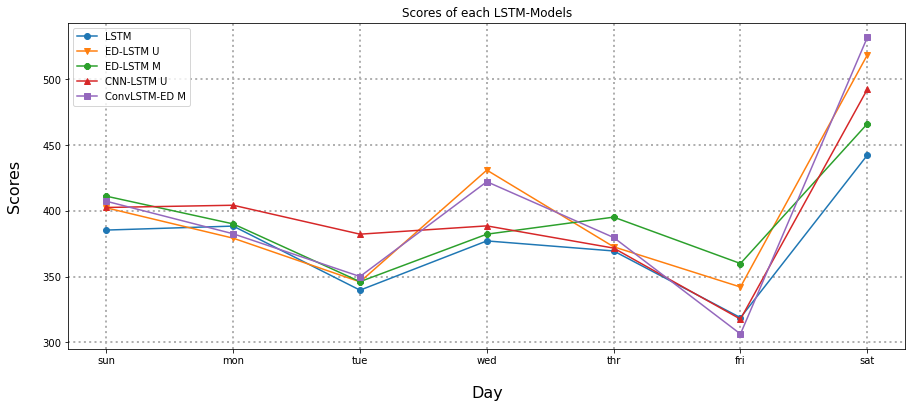

In [21]:
# PLOT SCORES for ALL MODELS
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']

pyplot.figure(figsize=(15, 6))
pyplot.plot(days, scoresLSTM_U  ,    marker='o', label='LSTM Univariate')
pyplot.plot(days, scoresEDLSTM_U,    marker='v', label='ED-LSTM Univariate')
pyplot.plot(days, scoresEDLSTM_M,    marker='8', label='ED-LSTM Multivariate')
pyplot.plot(days, scoresCNNLSTMED_U, marker='^', label='CNN-LSTM-ED Univariate')
pyplot.plot(days, scoresConvLSTM_M,  marker='s', label='ConvLSTM-ED Multivariate')
pyplot.ylabel("Scores",fontsize=16, labelpad=20)
pyplot.xlabel("Day",fontsize=16, labelpad=20)
pyplot.title("Scores of each LSTM-Models")
pyplot.grid(which='both', linestyle=':', linewidth=2)

pyplot.legend(['LSTM','ED-LSTM U','ED-LSTM M', 'CNN-LSTM U','ConvLSTM-ED M'])
pyplot.show()

In [22]:
# PREPARATION FOR PLOTTING
testIndr2  = testInd.ravel()   # Index time of data testing
datatestr2 = datatest.ravel()  # Data Testing

# RESULTS of PREDICTION each MODELS
predLSTM_U      = predLSTM_U.ravel()
predEDLSTM_U    = predEDLSTM_U.ravel()
predEDLSTM_M    = predEDLSTM_M.ravel()
predCNNLSTMED_U = predCNNLSTMED_U.ravel()
predConvLSTM_M  = predConvLSTM_M.ravel()

print(testIndr2[:5])
print(testIndr2.shape)
print(predLSTM_U[:5])
print(datatestr2[:5])

['2010-01-03T00:00:00.000000000' '2010-01-04T00:00:00.000000000'
 '2010-01-05T00:00:00.000000000' '2010-01-06T00:00:00.000000000'
 '2010-01-07T00:00:00.000000000']
(322,)
[1582.2565 1802.6289 1694.5236 1618.8352 1847.5106]
[2083.454 1604.132 2219.78  1777.18  1769.442]


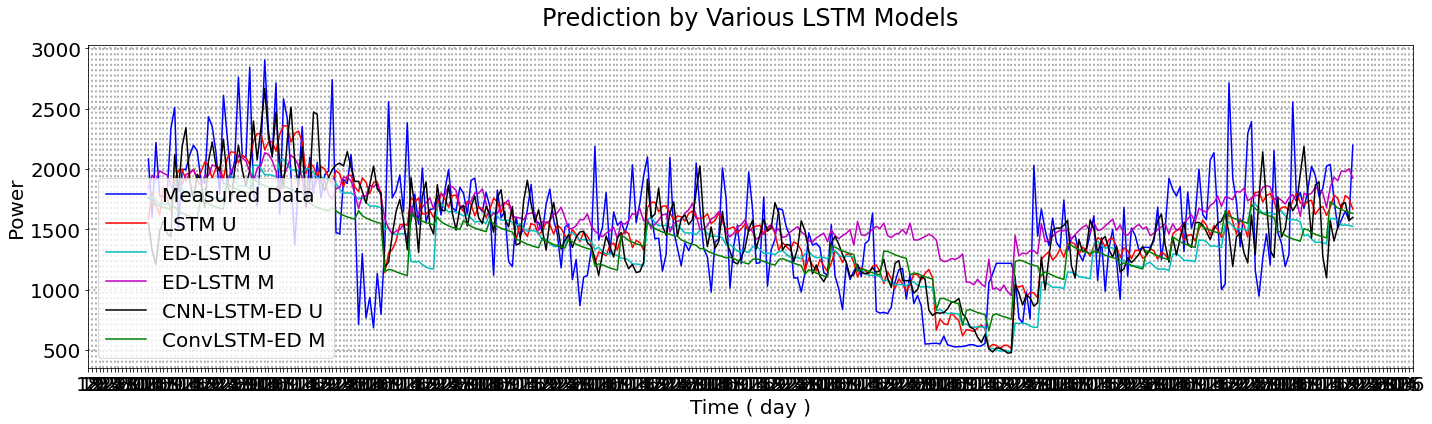

In [23]:
# PLOTTING
fig, ax = plt.subplots(figsize=(20,6))
# ax.margins(x=0.01)
# ax.margins(y=0.05)

ax.plot(testIndr2, datatestr2,'b'  )     # actual/TESTING DATA
ax.plot(testIndr2, predLSTM_U,'r')     # prediction - LSTM UNIVARIATE input & vector output model
ax.plot(testIndr2, predEDLSTM_U,'c')     # prediction - Encoder-Decoder LSTM Model With Univariate Input
ax.plot(testIndr2, predEDLSTM_M,'m')   # prediction - Encoder-Decoder LSTM Model With MULTIVARIATE Input
ax.plot(testIndr2, predCNNLSTMED_U,'k')  # prediction - CNN-LSTM Encoder-Decoder Model With UNIVARIATE Input
ax.plot(testIndr2, predConvLSTM_M,'g') # prediction - ConvLSTM Encoder-Decoder Model With MULTIVARIATE Input

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
# ax.set_xticklabels(np.arange(1, 34, 1))

# for line in ax.get_lines():
#     if line.get_label() == '_line0':
#         line.set_linewidth(2)
#         line.set_color('blue')
#     elif line.get_label() == '_line1':
#         line.set_linewidth(2)
#         line.set_linestyle('-.')
#         line.set_color('red')

ax.set_title('Prediction by Various LSTM Models',pad=20, fontdict={'fontsize':24})
ax.set_ylabel('Power',fontdict={'fontsize':20})
ax.set_xlabel('Time ( day )',fontdict={'fontsize':20})

ax.tick_params(axis='both', which='major', labelsize=20)
# ax.set_xlim(0,len(target_test))
# ax.set_xlim(df_prediction.index[0],df_prediction.index[len(df_prediction)-1])
# ax.set_ylim(0,1.75)

leg = ax.legend(['Measured Data','LSTM U','ED-LSTM U','ED-LSTM M','CNN-LSTM-ED U','ConvLSTM-ED M'], fontsize=20)
plt.grid(which='both', linestyle=':', linewidth=2)
plt.tight_layout()

In [24]:
# PERFORMANCE OF THE MODEL    
import scipy.stats
from scipy.stats import linregress
modelname1 = 'LSTM Univariate'
modelname2 = 'ED-LSTM Univariate'
modelname3 = 'ED-LSTM Multivariate'
modelname4 = 'CNN-LSTM-ED Univariate'
modelname5 = 'ConvLSTM-ED Multivariate'

# MODEL 1
ccLSTM_U = scipy.stats.pearsonr(datatestr2, predLSTM_U)[0]
rmseLSTM_U = np.sqrt(np.mean((predLSTM_U - datatestr2)**2))
mapeLSTM_U = np.mean(np.abs((datatestr2 - predLSTM_U) / datatestr2 )) * 100
print('PERFORMANCE OF MODEL '+modelname1+':'); print(' ')
print('Correlation Coefficient value is ', np.round(ccLSTM_U,2))
print('RMSE value is ', np.round(rmseLSTM_U,2))
print('MAPE value is ', np.round(mapeLSTM_U,2))
print(' ')

# MODEL 2
ccEDLSTM_U = scipy.stats.pearsonr(datatestr2, predEDLSTM_U)[0]
rmseEDLSTM_U = np.sqrt(np.mean((predEDLSTM_U - datatestr2)**2))
mapeEDLSTM_U = np.mean(np.abs((datatestr2 - predEDLSTM_U) / datatestr2 )) * 100
print('PERFORMANCE OF MODEL '+modelname2+':'); print(' ')
print('Correlation Coefficient value is ', np.round(ccEDLSTM_U,2))
print('RMSE value is ', np.round(rmseEDLSTM_U,2))
print('MAPE value is ', np.round(mapeEDLSTM_U,2))
print(' ')

# MODEL 3
ccEDLSTM_M = scipy.stats.pearsonr(datatestr2, predEDLSTM_M)[0]
rmseEDLSTM_M = np.sqrt(np.mean((predEDLSTM_M - datatestr2)**2))
mapeEDLSTM_M = np.mean(np.abs((datatestr2 - predEDLSTM_M) / datatestr2 )) * 100
print('PERFORMANCE OF MODEL '+modelname3+':'); print(' ')
print('Correlation Coefficient value is ', np.round(ccEDLSTM_M,2))
print('RMSE value is ', np.round(rmseEDLSTM_M,2))
print('MAPE value is ', np.round(mapeEDLSTM_M,2))
print(' ')

# MODEL 4
ccCNNLSTMED_U = scipy.stats.pearsonr(datatestr2, predCNNLSTMED_U)[0]
rmseCNNLSTMED_U= np.sqrt(np.mean((predCNNLSTMED_U - datatestr2)**2))
mapeCNNLSTMED_U = np.mean(np.abs((datatestr2 - predCNNLSTMED_U) / datatestr2 )) * 100
print('PERFORMANCE OF MODEL '+modelname4+':'); print(' ')
print('Correlation Coefficient value is ', np.round(ccCNNLSTMED_U,2))
print('RMSE value is ', np.round(rmseCNNLSTMED_U,2))
print('MAPE value is ', np.round(mapeCNNLSTMED_U,2))
print(' ')

# MODEL 5
ccConvLSTM_M  = scipy.stats.pearsonr(datatestr2, predConvLSTM_M)[0]
rmseConvLSTM_M= np.sqrt(np.mean((predConvLSTM_M - datatestr2)**2))
mapeConvLSTM_M = np.mean(np.abs((datatestr2 - predConvLSTM_M) / datatestr2 )) * 100
print('PERFORMANCE OF MODEL '+modelname5+':'); print(' ')
print('Correlation Coefficient value is ', np.round(ccConvLSTM_M,2))
print('RMSE value is ', np.round(rmseConvLSTM_M,2))
print('MAPE value is ', np.round(mapeConvLSTM_M,2))
print(' ')

PERFORMANCE OF MODEL LSTM Univariate:
 
Correlation Coefficient value is  0.64
RMSE value is  376.19
MAPE value is  21.48
 
PERFORMANCE OF MODEL ED-LSTM Univariate:
 
Correlation Coefficient value is  0.62
RMSE value is  402.75
MAPE value is  22.68
 
PERFORMANCE OF MODEL ED-LSTM Multivariate:
 
Correlation Coefficient value is  0.62
RMSE value is  394.59
MAPE value is  26.9
 
PERFORMANCE OF MODEL CNN-LSTM-ED Univariate:
 
Correlation Coefficient value is  0.61
RMSE value is  397.09
MAPE value is  22.02
 
PERFORMANCE OF MODEL ConvLSTM-ED Multivariate:
 
Correlation Coefficient value is  0.62
RMSE value is  402.41
MAPE value is  22.99
 


In [ ]:
# DOCUMENTATION:
# testIndr  = np.reshape(testInd, (46*7, 1))
# testIndr2 = testInd.ravel()
# datatestr = np.reshape(datatest, (46*7, 1))
# datatestr2  = datatest.ravel()

# predictionsr = np.reshape(predictions, (46*7, 1))
# predictionsrLSTM   = predictionsLSTM.ravel()
# predictionsrLSTMED = predictionsLSTMED.ravel()